# Percentile method

The goal is to show that causal impact is not related necessarily to the most central node. What defines a node to be most central depends on the context. Often a assumption of "connectedness" is made, i.e. nodes with high degree are deemed more important than nodes with lesser degree. What we propose is an alternative method using information theory which has several advantages. Primarily, information theory uses probability distributions, allowing (1) observation only to be used in ranking node on dynamic importance, and (2) are blind of the mechanisms that generate to these distributions; This allows for mapping dynamic importance in situations where there is no clear way, or no current method that allows for causal analysis of the system, e.g. the climate or complex-networks such as protein-protein networks.

Consequently, we hypothesize that nodes with that rank high in terms of centrality, does not necessarily reflect nodes with high causal impact. The metrics proposes, informational impact, in contrast is able to accurately reflect causal impact in complex dynamical networks

## The method
The direct hypothesis is that centrality metrics does not necessarily reflect high causal impact. Causal impact is defined as the integral of the KL-divergence between an intervened and unintervened distribution. Informational impact is defined similarly but using the probabilitiy distributions using the unintervened distribution. How can we assure that there exists only one driver-node in the network? In reality, we can't as it is currently unclear how to identify driver-nodes in complex dynamical networks; as such we extract the area under the curve per node for causal impact. The area under the curve, however, will not guarantee a singular node to be the driver-node in any arbritrary network structure. As such we porpose a method that exracts the number of driver-nodes using overlapping confidence interval method. This method extracts the max area under the curve value per simulations after which a confidence intervals are computed and estimated how many driver-nodes are present in this label-vector (figure X). 

The driver-set will be used as label indicator. We hypothesize that on average the percentile of informational impact will be higher for nodes identified as causally important than for any centrality metrics. 


In [1]:
import sys, os
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')
import matplotlib.pyplot as plt, numpy as np, networkx as nx
from Utils.stats import driverNodeEstimate
from Utils import IO

fn = 'tester.pickle'
for k, v in IO.loadPickle(fn).items():
    print(f'Loading {k}')
    globals()[k] = v

print(aucs.keys())
s = next(iter(settings))
setting = settings[s]



Loading aucs
Loading data
Loading rata
Loading settings
Loading coeffs
dict_keys(['/var/scratch/cveltere/tester/2019-10-07T12:37:57.770156', '/var/scratch/cveltere/tester/2019-10-07T12:37:59.585120', '/var/scratch/cveltere/tester/2019-10-07T12:38:01.219213', '/var/scratch/cveltere/tester/2019-10-14T07:46:52.816297', '/var/scratch/cveltere/tester/2019-10-14T07:46:53.453355', '/var/scratch/cveltere/tester/2019-10-14T07:46:55.128018', '/var/scratch/cveltere/tester/2019-10-14T07:47:19.581611', '/var/scratch/cveltere/tester/2019-10-16T10:54:41.340793', '/var/scratch/cveltere/tester/2019-10-16T10:54:44.511811', '/var/scratch/cveltere/tester/2019-10-16T10:54:47.722743', '/var/scratch/cveltere/tester/2019-10-16T10:54:48.274841', '/var/scratch/cveltere/tester/2019-10-16T10:54:48.281020', '/var/scratch/cveltere/tester/2019-10-16T10:54:59.050361', '/var/scratch/cveltere/tester/2019-10-16T15:57:15.895559', '/var/scratch/cveltere/tester/2019-10-16T15:57:24.802926', '/var/scratch/cveltere/tester/201

In [2]:
len(data)

16

In [3]:
%load_ext autoreload
%autoreload 2
from scipy.stats import percentileofscore as pcs
# estimate the max values
# tmp = np.array([i for i in aucs.values()])

from itertools import product
# ndata, nodes, ntrials, npulse, ntemp = tmp.shape
npulse = len(setting.get('pulseSizes')) + 1
ntemp  = len(setting.get('equilibrium')['ratios'])


    
# driverNodes = {key : np.zeros(npulse, ntemp, dtype = set) for key in data.keys()}
# driverNodes = np.zeros((ndata, npulse, ntemp), dtype = set)
# overlaps = {key : }
# overlaps    = np.zeros((ndata, npulse, ntemp), dtype = float)
alpha = .01

# idx = tmp.argmax(1) 



centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
#                    percolation = nx.percolation_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
#                    dispersion = nx.dispersion,\
#                     vote_rank = nx.algorithms.centrality.voterank,\
#                     second_order = nx.second_order_centrality,\
#                    current_flow = nx.current_flow_betweenness_centrality,\
                   )


conditions = len(centralities) + 1

overlaps    = {}
driverNodes = {}
pscores = {}

taucs = {}

from scipy import integrate
# setup dictionaries
for key in data:
    driverNodes[key] = np.zeros((npulse, ntemp), dtype = set)
    overlaps[key] = np.zeros((npulse, ntemp), dtype = float)
    pscores[key] = np.zeros((npulse, ntemp, conditions))
    
    taucs[key] = np.trapz(data.get(key), axis = -1)

from Utils.stats import driverNodeEstimateSEM
kind = 'weak'
combinations = product(*[data.keys(), range(npulse), range(ntemp)])
for (dataidx, pulseidx, tempidx) in combinations:
    # get result data
    graph = settings[dataidx].get('graph')
    model = settings[dataidx].get('model')
    
#     model = model(graph)
    
    # get aucs and create ranks
    idx   = aucs.get(dataidx)
    ranks = idx[..., pulseidx, tempidx].argmax(0)
#     print(dataidx, pulseidx, tempidx, ranks)
    # estimate driver nodes 
#     drivers = driverNodeEstimate(ranks.tolist(), alpha = alpha)
    drivers = driverNodeEstimateSEM(taucs[dataidx][..., pulseidx, tempidx], alpha = alpha)
    driverNodes[dataidx][pulseidx, tempidx] = drivers
    
    midrivers = driverNodes[dataidx][0, tempidx]
    
    inter = drivers.intersection(midrivers)
    union = drivers.union(midrivers)

    overlap = len(inter) / len(union)
    overlaps[dataidx][pulseidx, tempidx] = overlap 
    
    
    d = aucs[dataidx][:, :, 0, tempidx]
    d = d.mean(1) # average over trials
    
    e = d[list(drivers)]
    d = [i for idx, i in enumerate(d) if idx not in drivers] 
    d = np.array(d)
    
    score = np.mean([pcs(d, i, kind = kind) for i in e])
    
#     print('>>', dataidx, pulseidx, tempidx)
#     print(drivers, score)
    pscores[dataidx][pulseidx, tempidx, 0] = score
    
 
#     print(graph.nodes, dataidx)
#     print(dataidx, drivers)
    for cidx, (cent, cf) in enumerate(centralities.items()):
        centVals = cf(model.graph)
        
        vals = [centVals.get(model.rmapping[d]) for d in drivers]
        d = np.fromiter(centVals.values(), dtype = 'float')
        d = [i for idx, i in enumerate(d) if idx not in drivers]
        d = np.array(d)
        score = np.mean([pcs(d, i, kind = kind) for i in vals])
        pscores[dataidx][pulseidx, tempidx, cidx + 1] = score

# Overlap driver-node estimates

The figure below shows how the statistical procedure produces similar driver-node estimates applied the informaitonal impact data or the causal impact data.

<IPython.core.display.Javascript object>


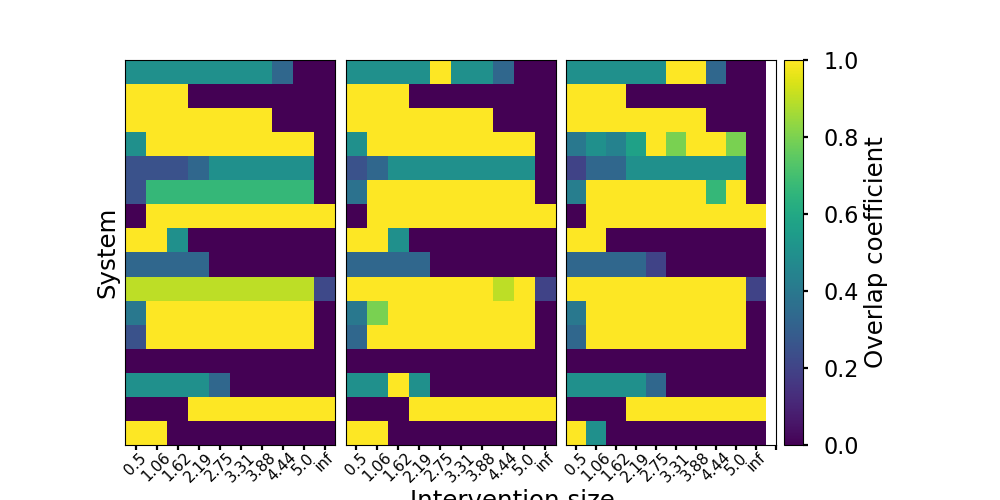

In [14]:
pulses = setting.get('pulseSizes')
xr = np.arange(len(pulses) + 1)
fig, ax = plt.subplots(1, ntemp, figsize = (10, 5), \
                       sharex = 'all', sharey = 'all')
for temp in range(ntemp):
    tax = ax[temp]
    h = tax.imshow([i[1:, temp] for i in overlaps.values()], \
                   vmin = 0, vmax = 1, aspect = 'auto')
    tax.set_yticks([])
    tax.set_xticks(xr)
    tax.set_xticklabels(np.round(pulses, 2), \
                    rotation = 45, fontsize = 11,\
                    )
    tax.tick_params(axis = 'x', pad = .1)
    
fig.subplots_adjust(wspace = 0.05)
mainax = fig.add_subplot(111, xticks = [], yticks = [], frameon = 0)
mainax.set_xlabel('Intervention size', labelpad = 32)
ax[0].set_ylabel('System')
fig.colorbar(h, ax = ax, label = 'Overlap coefficient', pad = 0.01)

fig.show()

In [5]:
# for k, v in settings.items():
#     print(v['modelSettings'])

# Main results

<IPython.core.display.Javascript object>


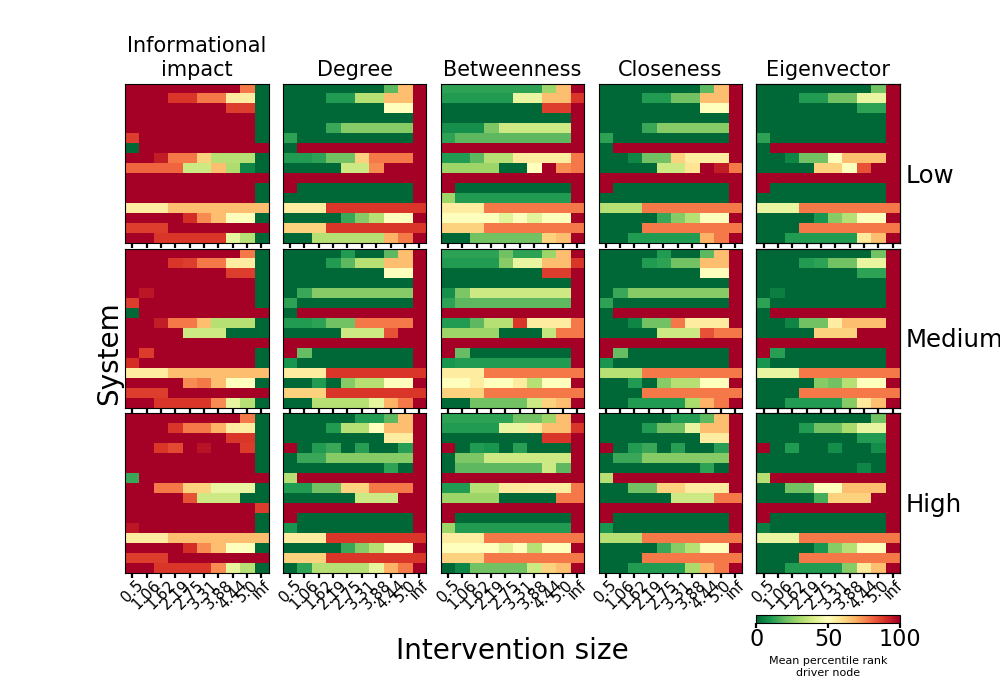

[0.5    1.0625 1.625  2.1875 2.75   3.3125 3.875  4.4375 5.        inf] 11


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Use the colorbar set_ticks() method instead.


In [48]:
%matplotlib notebook

gs = dict(height_ratios = [1, 1, 1, .2, .05])
# now use the driver nodes to estimate the percentiles
fig, ax = plt.subplots(ntemp + 2,\
                       conditions,\
                      sharey = 'row',\
                       sharex = 'row',\
                      gridspec_kw = gs,\
                      figsize = (10, 7))
#                       figsize = (15, 10))

conditionLabels = ['Informational\nimpact', *list(centralities.keys())]
conditionLabels = [i.replace('_', '\n').capitalize() for i in conditionLabels]
xr = np.arange(npulse)
pulses = np.array(setting.get('pulseSizes'))

print(pulses, npulse)
from scipy.ndimage import gaussian_filter
ratios = "Low Medium High".split()
for condition in range(conditions):
    for temp in range(ntemp):
        # setup axes
        tax = ax[temp, condition]
        tax.set_yticks([])
        tax.set_xticks(xr)
        tax.set_xticklabels(pulses.round(2), rotation = 45, \
                            fontsize = 11)
        
        tax.tick_params(axis = 'x',\
                       pad = 0.1)
        if temp != ntemp - 1:
            tax.set_xticklabels([])
        if temp == 0:
            title = conditionLabels[condition].replace('_', '\n').capitalize()
            tax.set_title(title, fontsize = 15)
        # plot
        d = np.array([i[1:, temp, condition] for i in pscores.values()])
#         d = np.asarray([gaussian_filter(i, .5) for i in d])
        
        h = tax.imshow(d, \
                       vmin = 0, vmax = 100,\
                       aspect = 'auto', \
                       cmap = plt.cm.RdYlGn_r,\
                      interpolation = None, ) 
        if condition == conditions - 1:
            yax = tax.twinx()
            yax.set_yticks ([])
            yax.set_ylabel(f"{ratios[temp]}", \
                           rotation = 0, horizontalalignment = 'left')
        if condition == conditions - 1 and temp == ntemp -1 :
            plt.colorbar(h, cax = ax[-1,condition], orientation = 'horizontal')
#             fig.colorbar(h, cax = ax[-1, condition], orientation = 'horitzontal')

for axi in ax[-2:, :].ravel()[:-1]:
    axi.axis('off')
ax[-1, -1].set_xticks([0, 100])
ax[-1, -1].tick_params(axis = 'x', pad = 0.01)
ax[-1, -1].set_xlabel('Mean percentile rank\ndriver node', fontsize = 8)

fig.subplots_adjust(hspace = .05, wspace = .10)
# fig.colorbar(h, ax = ax[:2, :], pad = .01, \
#              label = 'Average percentile score of drivers')
mainax = fig.add_subplot(111, frameon = 0, \
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Intervention size', fontsize = 20,  labelpad = 10)
mainax.set_ylabel('System', fontsize = 20, labelpad = 1.5)
fig.show()


Average rank score for the driver-nodes identified by the statistical procedure above for different estimators and across increasing noise (rows). Visually, we see that informational impact scores higher on average (quantified below). Importantly, as the intervention size increases, informational impact will lose its performance, however centrality metrics will improve.  

<IPython.core.display.Javascript object>


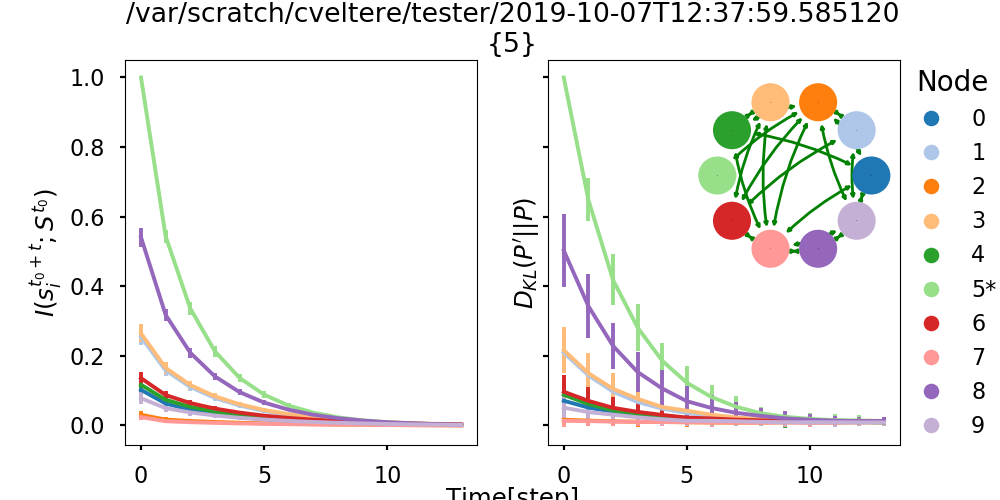

interactive(children=(Select(description='dataName', options=('/var/scratch/cveltere/tester/2019-10-07T12:37:5…

In [23]:
%matplotlib notebook
import ipywidgets as widgets
from scipy.stats import sem
from Utils.plotting import addGraphPretty

# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)


pulseSlider = widgets.IntSlider(min = 1, max = npulse - 1)


%matplotlib notebook
fig, (left, right) = plt.subplots(1, 2, figsize = (10, 5), sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]', labelpad = 30)
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = data.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    drivers = driverNodes[dataName][pulse, temp]
    
    mainax.set_title(dataName + "\n" + str(drivers))
    g = settings.get(dataName).get('graph')
    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * np.std(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.4, 0.4, .6, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], \
                      sems[node, 0, temp], \
                      color = colors[node],\
                      label = node)
        right.errorbar(xr, means[node, pulse, temp], \
                       sems[node, pulse, temp], \
                       color = colors[node],\
                       label = node)
    
    
    elems = [plt.Line2D([], [], color = colors[node], \
                      label = f'{node}{"*" if node in drivers else ""}', marker = 'o', linestyle = 'None') for node in range(nodes)]
    left.set_ylabel(r'$I(s_i^{t_0 + t} ; S^{t_0})$')
    right.set_ylabel(r"$D_{KL}(P' \vert \vert P)$")
    right.legend(handles = elems, \
                 bbox_to_anchor = (1.0, 1), loc = 'upper left',\
                title = 'Node', title_fontsize = 20,\
                frameon = 0,\
                borderaxespad = 0)
    print(dataName)
fig.show()



<IPython.core.display.Javascript object>


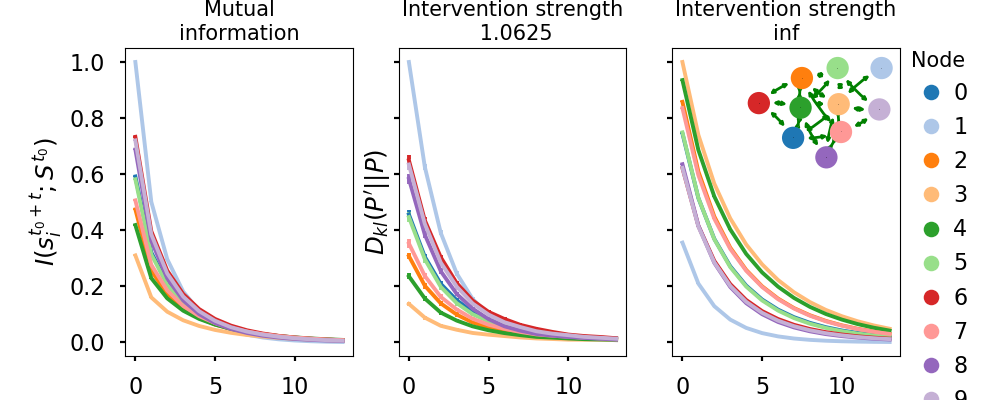

In [24]:
# make panel highlighting a transition of driver-nodes for nudge sizes
dataname = '/var/scratch/cveltere/tester/2019-10-16T15:57:27.814220'
tmp = data[dataname]
nodes, trials, pulses, temps, deltas = tmp.shape
fig, ax = plt.subplots(1, 3, figsize = (10, 4),\
                      sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [], \
                        yticks = [], \
                        )
mainax.set_xlabel('Time (step)', labelpad = 32)

xr = np.arange(tmp.shape[-1])
idx = [0, 1, -1]

pulses = settings[dataname].get('pulseSizes')
labels = ['Mutual\ninformation',\
          f'Intervention strength\n {pulses[idx[1]]}',\
          f'Intervention strength\n{pulses[idx[-1]]}',\
         ]

graph = settings[dataname].get('graph')
colors = plt.cm.tab20(range(graph.number_of_nodes()))
for i in range(3):
    axi = ax[i]
    
    j = idx[i]
    if i == 0:
        axi.set_ylabel('$I(s_i^{t_0 + t}; S^{t_0})$')
    elif i == 1:
        axi.set_ylabel("$D_{kl}(P' || P)$")
    else:
        inax = axi.inset_axes([.3, .44, .7, .7])
        pos = nx.kamada_kawai_layout(graph)
#         pos = nx.rescale_layout(pos, 1)
        addGraphPretty(graph, ax = inax, positions = pos)
        inax.axis('off')
    for k in range(nodes):
        axi.errorbar(xr, tmp.mean(1)[k, j, 0], 2 * sem(tmp, 1)[k, j, 0], \
                     color = colors[k])
    axi.set_title(labels[i], fontsize = 15)
elems = []
for k in range(nodes):
    elems.append(plt.Line2D(\
                            [], [],\
                            color = colors[k],\
                            marker = 'o',\
                            linestyle = 'none',\
                           label =  k))
axi.legend(handles = elems, loc ='upper left', bbox_to_anchor = (1, 1.02), \
          frameon = 0, borderaxespad = 0, \
           handletextpad = 0, title = 'Node', title_fontsize = 15)
    
fig.show()


<IPython.core.display.Javascript object>


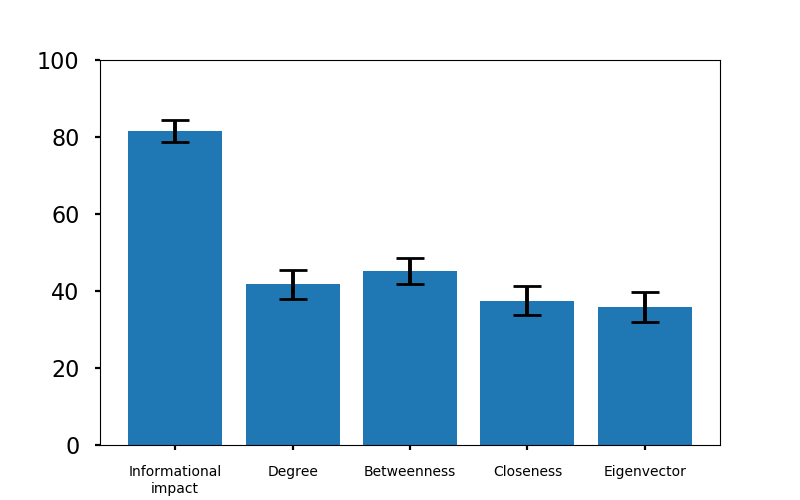

<IPython.core.display.Javascript object>


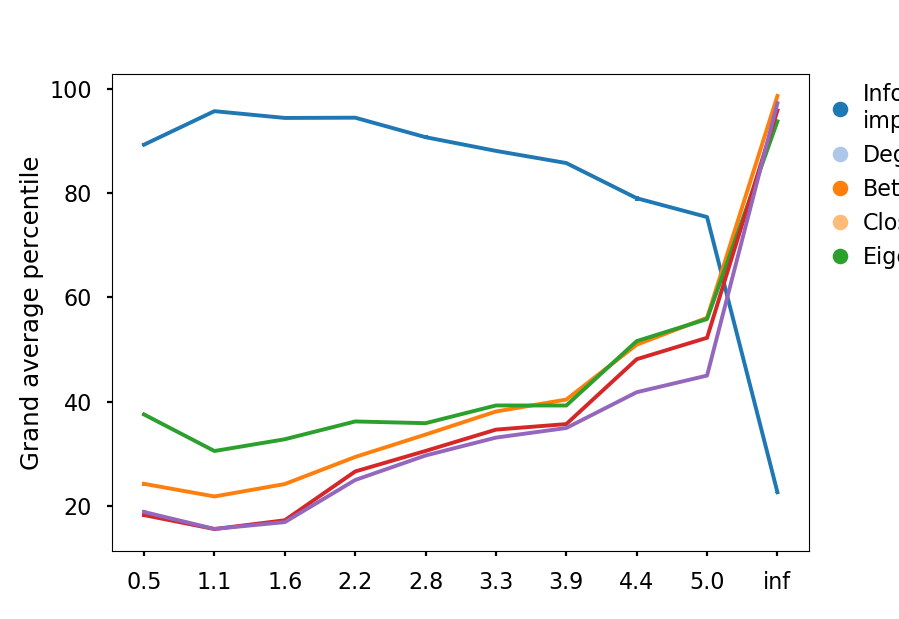

In [20]:
%matplotlib notebook
# plot grand averages 
from scipy.stats import sem
# s = pscores.shape
scores = np.array([i for i in pscores.values()])
ndata, npulse, ntemp, _ = scores.shape
# print(scores[:, 0])
scores = scores[:, 1:]
means = scores.reshape(-1, conditions).mean(0)
sems  = sem(scores.reshape(-1, conditions), 0)
# sems  = np.std(scores.reshape(-1, conditions), 0)
fig, ax = plt.subplots(figsize = (8, 5))
xrr  = np.arange(means.size)
ax.errorbar(xrr, means, 2 * sems, \
            linestyle = 'none', \
            capsize = 10, capthick = 2,\
            color = 'k')
ax.bar(xrr, means)
ax.set_ylim(0, 100)
ax.set_xticks(xrr)
ax.set_xticklabels(conditionLabels, fontsize = 10)
fig.show()

ascores = scores.mean(0).mean(1)
asems   = sem(sem(scores, 0), 1)
# asems   = np.std(np.std(scores, 0), 1)

# plot averages per nudge size
xrr = np.arange(len(ascores))
fig, ax = plt.subplots(figsize = (8, 5))
elems = []
colors = plt.cm.tab20(range(10))
for cond in range(conditions):
    ax.errorbar(xrr, ascores[:, cond], asems[:, cond], \
                label = conditionLabels[cond])
    elem = plt.Line2D([], [], color = colors[cond], marker = 'o', linestyle = 'none',\
                     label = conditionLabels[cond])
    elems.append(elem)
ax.legend(handles = elems, frameon = 0,\
          loc = 'upper left', \
          borderaxespad = 0, handletextpad = 0,\
          bbox_to_anchor = (1, 1))

ax.set_xticks(xrr)
pulses = np.asarray(pulses)
ax.set_xlabel('Intervention size', labelpad = 20)
ax.set_xticklabels(pulses.round(1))
ax.set_ylabel('Grand average percentile')
fig.show()

(16, 10, 3, 5)


<IPython.core.display.Javascript object>


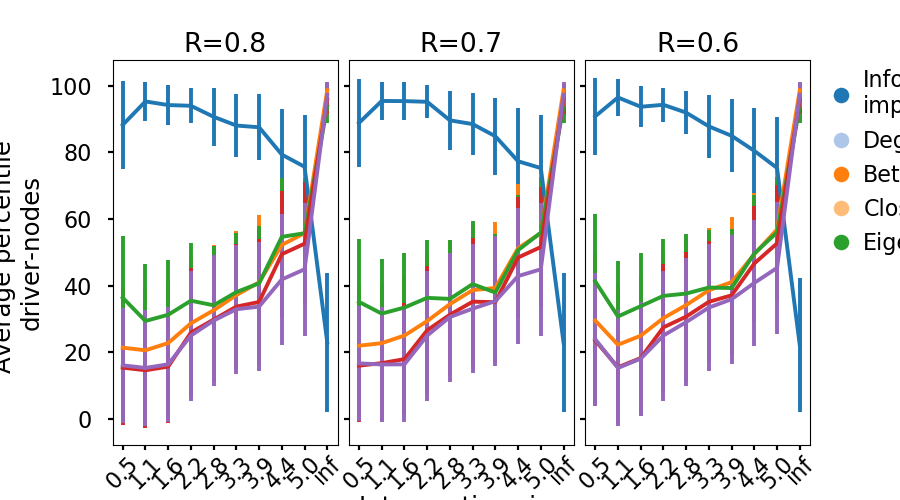

In [21]:
scores = np.array([i for i in pscores.values()])[:, 1:]
from mpl_toolkits.mplot3d import Axes3D
print(scores.shape)

x, y = np.meshgrid(np.arange(len(pulses)), range(3))
%matplotlib notebook
fig, ax = plt.subplots(1, 3, figsize = (9, 5), \
                      sharey = 'all',\
                      sharex = 'all')

xr = np.arange(pulses.size)
ratios = '0.8 0.7 0.6'.split()

for idx, axi in enumerate(ax):
    if idx == 0 :
        axi.set_ylabel("Average percentile \ndriver-nodes")
        
    elems = []
    for condition in range(conditions):
        axi.errorbar(xr, scores.mean(0)[:, idx, condition], \
                     2 * sem(scores, axis = 0)[:, idx, condition])
        elem = plt.Line2D([], [],\
                         color = colors[condition],\
                         label = conditionLabels[condition],\
                         marker = 'o',\
                         linestyle = 'none',\
                         )
        elems.append(elem)
    axi.set_xticks(xr)
    axi.set_title(f'R={ratios[idx]}')
    axi.set_xticklabels(pulses.round(1), rotation = 45)
    axi.tick_params(axis = 'x', pad = 2)
axi.legend(handles = elems, loc = 'upper left', bbox_to_anchor = (1, 1),\
          frameon = 0, borderaxespad = 0, handletextpad =0 )
#     for i in range(s.shape[0]):
#         ax.plot_surface(x, y, s[..., i], color = colors[idx])
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])

mainax.set_xlabel('Intervention size', labelpad = 36)
fig.subplots_adjust(hspace = 0.05, wspace = 0.05)
fig.show()

# List node sizes


<IPython.core.display.Javascript object>


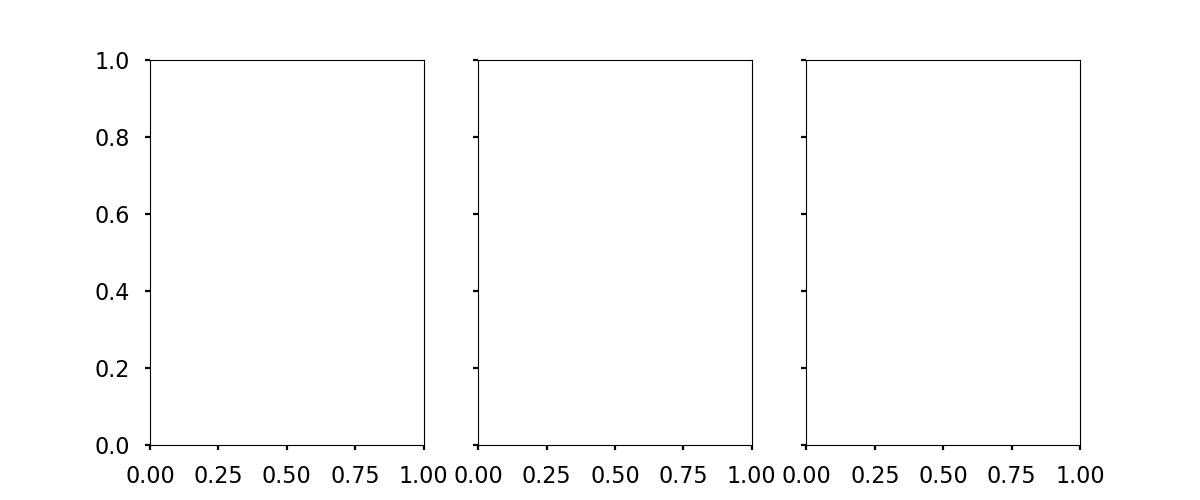

AttributeError: 'list' object has no attribute 'size'

In [25]:
%matplotlib notebook
tmp = np.array([i for i in driverNodes.values()])

fig, ax = plt.subplots(1, 3, sharex = 'all',\
                      sharey = 'all',\
                      figsize = (12, 5))

xr = np.arange(pulses.size)

labels = "Low Medium High".split()
for idx, axi in enumerate(ax):
    d = tmp[..., idx]
    s = d.shape
    print(s)
    d = np.array([len(i) for i in d.flat])
    d = d.reshape(s)
    h = axi.imshow(d[:, 1:], aspect = 'auto')
    axi.set_yticks([])
    axi.set_xticks(xr)
    axi.set_xticklabels(pulses.round(1), rotation = 45)
    axi.set_title(labels[idx])
fig.subplots_adjust(wspace = .05)
fig.colorbar(h, ax = ax, label = 'Number of driver-nodes',\
            pad = 0.01)
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [], \
                        yticks = [],\
                        )
mainax.set_ylabel('System')
mainax.set_xlabel('Intervention size', labelpad = 42)
fig.show()

In [12]:
def correctauc(vals, alpha):
    from scipy.stats import sem, norm
    # vals = node x trials
    
    vals = vals.copy()
    nodes, trials = vals.shape
    zdx = norm.ppf(1 - alpha / 2)
    means = vals.mean(1)
    sems  = np.std(vals, axis = 1) * zdx
    for node in range(nodes):
        idx = np.where(abs(vals[node] - means[node])**1 > sems[node])[0]
#         print(idx)
        vals[node, idx] = np.NaN
        
        vals[node, idx] = np.nanmean(vals[node])
    return vals
taucs = {}

from itertools import product
alpha = .01
for k, v in aucs.items():
    v = v.copy()
    node, trials, npulse, ntemp = v.shape
    for c in product(*[range(i) for i in (npulse, ntemp)]):
        v[..., c[0], c[1]] = correctauc( v[..., c[0], c[1]], alpha)
    
    taucs[k] = v
        
    
    

In [13]:
dataname = '../Data/tester/2019-10-16T10:54:59.050361'
graph = settings.get(dataname).get('')


AttributeError: 'NoneType' object has no attribute 'get'